In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#Checking for GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1070920214371066057
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1469199154
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18246953556560536973
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
#Importing the Dataset with TDS
dataset = pd.read_csv('2021_10_31_cleaned_lake_dataset_with_tds.csv', header=0, index_col=0)
dataset = dataset.rename(columns={'actual_conductivity':'cond', 'total_dissolved_solids':'tds', 'do_concentration':'do', 'turbidity':'turb', 'chl-a_concentration':'chl-a', 'temperature':'temp'})
dataset = dataset[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a']]
dataset.sort_index()
dataset.head()

,temp,cond,do,tds,turb,chl-a
datetime,,,,,,
2019-02-20 12:00:00,29.55674,92.12651,6.491213,0.055088,32.86783,39.64875
2019-02-20 12:10:00,29.59175,92.22813,6.724226,0.055115,24.30492,40.57396
2019-02-20 12:20:00,29.57693,91.93182,6.677357,0.054952,47.46174,40.88269
2019-02-20 12:30:00,29.63118,92.45161,7.540924,0.055210,55.04100,46.67803
2019-02-20 12:40:00,29.64378,92.78736,7.629431,0.055398,26.58170,47.05107


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF19A524A8>,
      dtype=object)

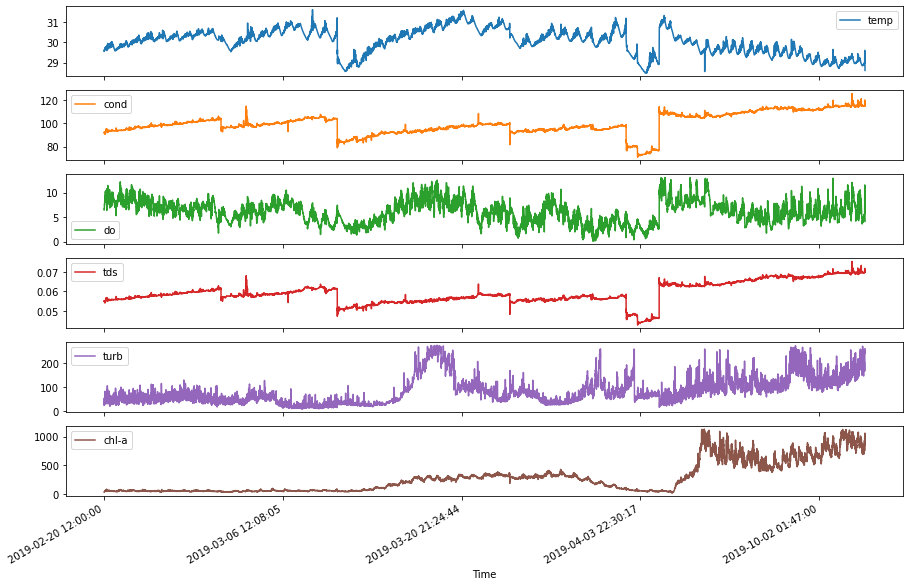

In [3]:
dataset.sort_index()[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a']].plot(subplots=True, figsize = (15,10), xlabel= 'Time')

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
#Preparing Input & Output Features
input_features = dataset[:]
target_labels = input_features.pop('chl-a')
print(input_features.shape)
print(target_labels.shape)
target_labels.head()

(8516, 5)
(8516,)


datetime
2019-02-20 12:00:00    39.64875
2019-02-20 12:10:00    40.57396
2019-02-20 12:20:00    40.88269
2019-02-20 12:30:00    46.67803
2019-02-20 12:40:00    47.05107
Name: chl-a, dtype: float64

In [6]:
#Scaling Inputs
input_values = input_features.values
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_input_features = scaler.fit_transform(input_values)
print(scaled_input_features.shape)

(8516, 5)
ERROR! Session/line number was not unique in database. History logging moved to new session 222


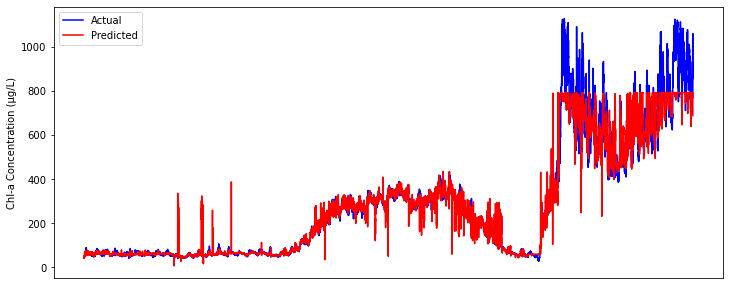

(8516, 1)


In [7]:
#Adding MLP prediction for whole dataset
model = keras.models.load_model('mlp_whole_dataset')

y_pred_mlp = pd.DataFrame(model.predict(scaled_input_features))
y_actual = pd.DataFrame(target_labels)

plt.figure(figsize=(12,5))

plt.ylabel('Chl-a Concentration (µg/L)')

plt.plot(y_actual, color='blue', label = 'Actual')
plt.plot(y_pred_mlp, color='red', label = 'Predicted')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.legend()
plt.show()
print(y_pred_mlp.shape)

In [1]:
y_pred_mlp.head()

NameError: name 'y_pred_mlp' is not defined

In [ ]:
augmented_input_features = input_features[:]
augmented_input_features = augmented_input_features.reset_index()
# frames = [augmented_input_features, y_pred_mlp]
# augmented_input_features = pd.concat(frames)
#['chl-a_pred'] = y_pred_mlp_val.tolist()
augmented_input_features['chl-a_pred'] = y_pred_mlp
datetime = augmented_input_features.pop('datetime')
augmented_input_features.head()
augmented_input_features.sort_index()[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a_pred']].plot(subplots=True, figsize = (15,10), xlabel= 'Time')
#print(augmented_input_features.shape)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-bd3e09d839ac>", line 6, in <module>
    augmented_input_features['chl-a_pred'] = y_pred_mlp
NameError: name 'y_pred_mlp' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\IPython\core\ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context,

In [121]:
#Preparing sliding window dataset 
n_intervals = 2
reframed_inputs = series_to_supervised(augmented_input_features, n_intervals, 1)
print(reframed_inputs.shape)
reframed_inputs.head()

(8514, 18)


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
2,29.55674,92.12651,6.491213,0.055088,32.86783,41.753815,29.59175,92.22813,6.724226,0.055115,24.30492,38.784790,29.57693,91.93182,6.677357,0.054952,47.46174,38.150200
3,29.59175,92.22813,6.724226,0.055115,24.30492,38.784790,29.57693,91.93182,6.677357,0.054952,47.46174,38.150200,29.63118,92.45161,7.540924,0.055210,55.04100,52.644760
4,29.57693,91.93182,6.677357,0.054952,47.46174,38.150200,29.63118,92.45161,7.540924,0.055210,55.04100,52.644760,29.64378,92.78736,7.629431,0.055398,26.58170,50.181847
5,29.63118,92.45161,7.540924,0.055210,55.04100,52.644760,29.64378,92.78736,7.629431,0.055398,26.58170,50.181847,29.63245,91.78815,7.566510,0.054812,34.21025,45.375801
6,29.64378,92.78736,7.629431,0.055398,26.58170,50.181847,29.63245,91.78815,7.566510,0.054812,34.21025,45.375801,29.64501,91.57467,7.912216,0.054673,52.89904,49.550537


In [122]:
#Scale augmented inputs
aug_input_values = reframed_inputs.values
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_aug_input_features = scaler.fit_transform(aug_input_values)
print(scaled_aug_input_features.shape)
print(scaled_aug_input_features[0])

(8514, 18)
[-0.30662061 -0.22775965 -0.01916037 -0.2485787  -0.8230044  -0.90525443
 -0.28418449 -0.22402965  0.01668354 -0.24691552 -0.88823203 -0.91279721
 -0.29368187 -0.23490581  0.00947378 -0.25699747 -0.71183586 -0.91440937]


In [123]:
#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(scaled_aug_input_features, target_labels[n_intervals:], test_size=0.2, shuffle=False)

In [124]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6811, 18)
(1703, 18)
(6811,)
(1703,)


In [125]:
# reshape input to be 3D [samples, timesteps, features]
# x_train = pd.DataFrame(x_train)
# x_test= pd.DataFrame(x_test)
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, x_test.shape)

(6811, 1, 18) (1703, 1, 18)


In [130]:
#Designing the LSTM Network

model = Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False)) #, return_sequences=True
model.add(Dropout(0.2))
# model.add(LSTM(16, return_sequences=False))
# model.add(Dropout(0.3))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse'])
model.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 219
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 32)                6528      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
_________________________________________________________________


In [132]:
#Early stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

#Fitting the model
history = model.fit(x_train, y_train, epochs=10000, batch_size = 512, validation_data = (x_test, y_test), verbose=2, shuffle=False, callbacks=[early_stop])


Train on 6811 samples, validate on 1703 samples
Epoch 1/10000
 - 0s - loss: 21.1767 - mae: 21.1767 - mse: 2086.0913 - val_loss: 154.0570 - val_mae: 154.0571 - val_mse: 36943.4375
Epoch 2/10000
 - 0s - loss: 21.3688 - mae: 21.3688 - mse: 2192.6689 - val_loss: 154.2263 - val_mae: 154.2263 - val_mse: 37015.0977
Epoch 3/10000
 - 0s - loss: 21.3485 - mae: 21.3485 - mse: 2155.7466 - val_loss: 154.0702 - val_mae: 154.0703 - val_mse: 36944.4414
Epoch 4/10000
 - 0s - loss: 21.4272 - mae: 21.4272 - mse: 2192.4912 - val_loss: 153.8838 - val_mae: 153.8838 - val_mse: 36856.6719
Epoch 5/10000
 - 0s - loss: 21.7406 - mae: 21.7406 - mse: 2230.9851 - val_loss: 153.8309 - val_mae: 153.8309 - val_mse: 36830.6953
Epoch 6/10000
 - 0s - loss: 21.2137 - mae: 21.2137 - mse: 2146.7852 - val_loss: 154.1961 - val_mae: 154.1961 - val_mse: 36988.4844
Epoch 7/10000
 - 0s - loss: 20.8671 - mae: 20.8671 - mse: 2022.1327 - val_loss: 154.3503 - val_mae: 154.3503 - val_mse: 37052.2383
Epoch 8/10000
 - 0s - loss: 21.1701

Epoch 63/10000
 - 0s - loss: 21.3563 - mae: 21.3563 - mse: 2184.5139 - val_loss: 154.7789 - val_mae: 154.7789 - val_mse: 37112.8164
Epoch 64/10000
 - 0s - loss: 21.0742 - mae: 21.0742 - mse: 1998.5679 - val_loss: 154.8105 - val_mae: 154.8105 - val_mse: 37131.9883
Epoch 65/10000
 - 0s - loss: 21.1143 - mae: 21.1143 - mse: 2118.1406 - val_loss: 154.8182 - val_mae: 154.8182 - val_mse: 37138.2539
Epoch 66/10000
 - 0s - loss: 21.2030 - mae: 21.2030 - mse: 2047.9574 - val_loss: 154.8868 - val_mae: 154.8868 - val_mse: 37157.9648
Epoch 67/10000
 - 0s - loss: 21.1570 - mae: 21.1570 - mse: 2045.0529 - val_loss: 154.8578 - val_mae: 154.8578 - val_mse: 37144.1250
Epoch 68/10000
 - 0s - loss: 21.0515 - mae: 21.0515 - mse: 2029.3519 - val_loss: 154.8148 - val_mae: 154.8148 - val_mse: 37130.5781
Epoch 69/10000
 - 0s - loss: 21.4904 - mae: 21.4904 - mse: 2102.1726 - val_loss: 154.6734 - val_mae: 154.6734 - val_mse: 37065.2930
Epoch 70/10000
 - 0s - loss: 21.3325 - mae: 21.3325 - mse: 2193.1465 - val_l

Epoch 125/10000
 - 0s - loss: 21.1231 - mae: 21.1231 - mse: 1948.3514 - val_loss: 155.1401 - val_mae: 155.1401 - val_mse: 37251.2852
Epoch 126/10000
 - 0s - loss: 21.2101 - mae: 21.2101 - mse: 2002.4670 - val_loss: 155.0943 - val_mae: 155.0943 - val_mse: 37224.5703
Epoch 127/10000
 - 0s - loss: 21.1653 - mae: 21.1653 - mse: 2033.9745 - val_loss: 155.1867 - val_mae: 155.1867 - val_mse: 37249.9688
Epoch 128/10000
 - 0s - loss: 21.4117 - mae: 21.4117 - mse: 2155.4634 - val_loss: 155.2641 - val_mae: 155.2641 - val_mse: 37271.3594
Epoch 129/10000
 - 0s - loss: 20.8610 - mae: 20.8610 - mse: 1974.0367 - val_loss: 155.2818 - val_mae: 155.2818 - val_mse: 37269.9375
Epoch 130/10000
 - 0s - loss: 21.2922 - mae: 21.2922 - mse: 2155.5559 - val_loss: 155.2188 - val_mae: 155.2188 - val_mse: 37236.5273
Epoch 131/10000
 - 0s - loss: 21.1774 - mae: 21.1774 - mse: 2080.5244 - val_loss: 155.2675 - val_mae: 155.2675 - val_mse: 37254.9883
Epoch 132/10000
 - 0s - loss: 21.1596 - mae: 21.1596 - mse: 2072.4539

Epoch 187/10000
 - 0s - loss: 21.1136 - mae: 21.1136 - mse: 2003.1014 - val_loss: 154.5857 - val_mae: 154.5857 - val_mse: 36923.2031
Epoch 188/10000
 - 0s - loss: 21.2376 - mae: 21.2376 - mse: 2051.5156 - val_loss: 154.6236 - val_mae: 154.6236 - val_mse: 36935.9766
Epoch 189/10000
 - 0s - loss: 21.3828 - mae: 21.3828 - mse: 2167.6389 - val_loss: 154.8653 - val_mae: 154.8653 - val_mse: 37038.9258
Epoch 190/10000
 - 0s - loss: 20.9369 - mae: 20.9369 - mse: 1979.6826 - val_loss: 154.7812 - val_mae: 154.7812 - val_mse: 36990.6367
Epoch 191/10000
 - 0s - loss: 21.2982 - mae: 21.2982 - mse: 2078.2952 - val_loss: 154.8645 - val_mae: 154.8645 - val_mse: 37023.9141
Epoch 192/10000
 - 0s - loss: 21.3268 - mae: 21.3268 - mse: 2094.7981 - val_loss: 154.7192 - val_mae: 154.7192 - val_mse: 36956.4727
Epoch 193/10000
 - 0s - loss: 20.7921 - mae: 20.7921 - mse: 1912.7546 - val_loss: 154.8441 - val_mae: 154.8441 - val_mse: 37002.8867
Epoch 194/10000
 - 0s - loss: 21.1140 - mae: 21.1140 - mse: 2006.7347

In [102]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
4358,95.936528,95.936531,15073.870117,10.507561,10.507560,1114.306885,4358
4359,95.742295,95.742294,15025.838867,10.571029,10.571029,1112.315796,4359
4360,95.936860,95.936859,15068.218750,10.607089,10.607089,1116.673828,4360
4361,95.759851,95.759857,15023.755859,10.520166,10.520166,1109.946411,4361
4362,95.895462,95.895454,15064.939453,10.419506,10.419506,1112.969971,4362


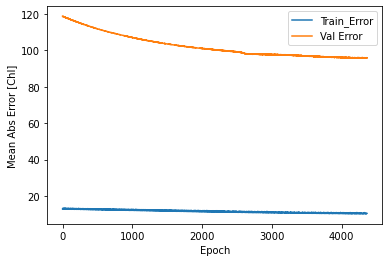

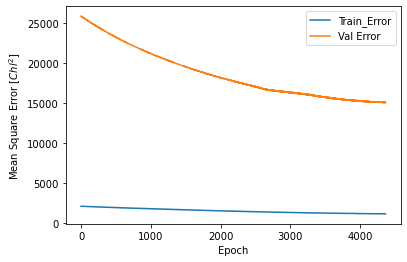

In [103]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Chl]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train_Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label='Val Error')
    plt.legend()
   # plt.ylim([0,20])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Chl^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train_Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label='Val Error')
    plt.legend()
    #plt.ylim([0,100])
    
plot_history(history)

In [104]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} Chlorophyll".format(mae))

Testing set Mean Abs Error: 95.90 Chlorophyll


In [ ]:
yhat = pd.DataFrame(model.predict(x_test))
y_actual = pd.DataFrame(y_test)

plt.figure(figsize=(12,5))
#plt.xlabel('Actual vs Predicted Chl-a')
#plt.xticks(predicted_y, predicted_y.index.values)

plt.ylabel('Chl-a Concentration (µg/L)')

plt.plot(y_actual, color='blue', label = 'Actual')

plt.plot(yhat, color='red', label = 'Predicted')

ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.legend()
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-109-64c9651a0a4e>", line 1, in <module>
    yhat = pd.DataFrame(model.predict(x_test))
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\keras\engine\training.py", line 1441, in predict
    x, _, _ = self._standardize_user_data(x)
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\keras\engine\training.py", line 579, in _standardize_user_data
    exception_prefix='input')
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\keras\engine\training_utils.py", line 135, in standardize_input_data
    'with shape ' + str(data_shape))
ValueError: Error when checking input: expected dense_166_input to have 2 dimensions, but got array with shape (1703, 1, 18)

During handling of the above exception, another exception occurred:


In [ ]:
from math import sqrt
yhat = model.predict(x_test)
yhat_trn = model.predict(x_train)
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

rmse = sqrt(mean_squared_error(y_train, yhat_trn))
print('Train RMSE: %.3f' % rmse)

print('Test R2 Score: ', r2_score(y_test, yhat))

print('Train R2 Score: ', r2_score(y_train, yhat_trn))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-109-1b7ee8da0fa8>", line 2, in <module>
    yhat = model.predict(x_test)
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\keras\engine\training.py", line 1441, in predict
    x, _, _ = self._standardize_user_data(x)
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\keras\engine\training.py", line 579, in _standardize_user_data
    exception_prefix='input')
  File "C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\keras\engine\training_utils.py", line 135, in standardize_input_data
    'with shape ' + str(data_shape))
ValueError: Error when checking input: expected dense_166_input to have 2 dimensions, but got array with shape (1703, 1, 18)

During handling of the above exception, another exception occurred:

Traceback (mo

In [ ]:
#Save Model for later use
#model.save('mlp_whole_dataset')
# model2 = keras.models.load_model('mlp_feb_mar')

# yhat = pd.DataFrame(model2.predict(scaled_test_rand))
# y_actual = pd.DataFrame(test_labels_rand)

# plt.figure(figsize=(12,5))
# #plt.xlabel('Actual vs Predicted Chl-a')
# #plt.xticks(predicted_y, predicted_y.index.values)


# plt.ylabel('Chl-a Concentration (µg/L)')





# plt.plot(y_actual, color='blue', label = 'Actual')
# plt.plot(yhat, color='red', label = 'Predicted')
# ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
# plt.legend()
# plt.show()